### Necessary Imports

In [49]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import json
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

### Input data file containing rideshare trip origin coordinates (pickup) and associated ride fares

In [3]:
trip = pd.read_csv(r'C:\Misc\Interview\Data_Mining\uber_trips_jan_march_2019.csv')

### Quick view of trip data

In [4]:
trip.head()

,Unnamed: 0,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,...,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,m_s_ratio,t_s_ratio,value,hour,2hr_slot,3hr_slot,Pickup_Neighborhood
0,0,2019-01-07 14:30:00,2019-01-07 14:45:00,1167.0,3.8,10.0,3.0,2.55,15.55,False,...,-87.653614,41.962179,-87.645379,0.003256,0.013325,L,14,8,5,"WICKER PARK,WEST TOWN"
1,3,2019-01-26 18:00:00,2019-01-26 18:15:00,1590.0,3.8,12.5,0.0,2.55,15.05,False,...,-87.637844,41.921877,-87.664078,0.002390,0.009465,L,18,10,7,RIVER NORTH
2,4,2019-02-10 17:45:00,2019-02-10 18:00:00,977.0,3.0,7.5,2.0,2.55,12.05,False,...,-87.641184,41.885281,-87.657233,0.003071,0.012334,L,17,9,6,OLD TOWN
3,5,2019-01-27 12:30:00,2019-01-27 12:45:00,592.0,2.0,5.0,0.0,2.55,7.55,False,...,-87.646293,41.904935,-87.649907,0.003378,0.012753,L,12,7,5,LINCOLN PARK
4,6,2019-03-02 16:15:00,2019-03-02 16:15:00,477.0,0.9,5.0,0.0,2.55,7.55,False,...,-87.643023,41.943237,-87.643471,0.001887,0.015828,H,16,9,6,LAKE VIEW


### Data Cleansing

In [10]:
#Check record counts for each column to ensure consistency
trip.count()

Unnamed: 0                    165576
Trip Start Timestamp          165576
Trip End Timestamp            165576
Trip Seconds                  165576
Trip Miles                    165576
Fare                          165576
Tip                           165576
Additional Charges            165576
Trip Total                    165576
Shared Trip Authorized        165576
Trips Pooled                  165576
Pickup Centroid Latitude      165576
Pickup Centroid Longitude     165576
Dropoff Centroid Latitude     165576
Dropoff Centroid Longitude    165576
m_s_ratio                     165576
t_s_ratio                     165576
value                         165576
hour                          165576
2hr_slot                      165576
3hr_slot                      165576
Pickup_Neighborhood           165576
dtype: int64

In [6]:
#Drop rows with na value
trip = trip.dropna()

In [11]:
#Check record counts
trip.count()

Unnamed: 0                    165576
Trip Start Timestamp          165576
Trip End Timestamp            165576
Trip Seconds                  165576
Trip Miles                    165576
Fare                          165576
Tip                           165576
Additional Charges            165576
Trip Total                    165576
Shared Trip Authorized        165576
Trips Pooled                  165576
Pickup Centroid Latitude      165576
Pickup Centroid Longitude     165576
Dropoff Centroid Latitude     165576
Dropoff Centroid Longitude    165576
m_s_ratio                     165576
t_s_ratio                     165576
value                         165576
hour                          165576
2hr_slot                      165576
3hr_slot                      165576
Pickup_Neighborhood           165576
dtype: int64

In [7]:
#Filter out shared trips (i.e. Uber pool)
trip = trip[trip['Shared Trip Authorized'] == False]

#Filter out tripes with 0 trip miles
trip = trip[trip['Trip Miles']>0]

#Filter out trips with less than 30 seconds trip seconds
trip = trip[trip['Trip Seconds']>30]

#Filter ouut trips that has odd miles to seconds ratio
#assuming the fastest average speed is 72m/h, we will filter out rows with m_s_ratio larger than 0.02
trip['m_s_ratio'] = trip['Trip Miles']/trip['Trip Seconds']
trip = trip[trip['m_s_ratio']<0.02]

#Quick view cleansed data file
trip.head()

,Unnamed: 0,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,...,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,m_s_ratio,t_s_ratio,value,hour,2hr_slot,3hr_slot,Pickup_Neighborhood
0,0,2019-01-07 14:30:00,2019-01-07 14:45:00,1167.0,3.8,10.0,3.0,2.55,15.55,False,...,-87.653614,41.962179,-87.645379,0.003256,0.013325,L,14,8,5,"WICKER PARK,WEST TOWN"
1,3,2019-01-26 18:00:00,2019-01-26 18:15:00,1590.0,3.8,12.5,0.0,2.55,15.05,False,...,-87.637844,41.921877,-87.664078,0.002390,0.009465,L,18,10,7,RIVER NORTH
2,4,2019-02-10 17:45:00,2019-02-10 18:00:00,977.0,3.0,7.5,2.0,2.55,12.05,False,...,-87.641184,41.885281,-87.657233,0.003071,0.012334,L,17,9,6,OLD TOWN
3,5,2019-01-27 12:30:00,2019-01-27 12:45:00,592.0,2.0,5.0,0.0,2.55,7.55,False,...,-87.646293,41.904935,-87.649907,0.003378,0.012753,L,12,7,5,LINCOLN PARK
4,6,2019-03-02 16:15:00,2019-03-02 16:15:00,477.0,0.9,5.0,0.0,2.55,7.55,False,...,-87.643023,41.943237,-87.643471,0.001887,0.015828,H,16,9,6,LAKE VIEW


In [13]:
#Check record counts
trip.count()

Unnamed: 0                    165576
Trip Start Timestamp          165576
Trip End Timestamp            165576
Trip Seconds                  165576
Trip Miles                    165576
Fare                          165576
Tip                           165576
Additional Charges            165576
Trip Total                    165576
Shared Trip Authorized        165576
Trips Pooled                  165576
Pickup Centroid Latitude      165576
Pickup Centroid Longitude     165576
Dropoff Centroid Latitude     165576
Dropoff Centroid Longitude    165576
m_s_ratio                     165576
t_s_ratio                     165576
value                         165576
hour                          165576
2hr_slot                      165576
3hr_slot                      165576
Pickup_Neighborhood           165576
dtype: int64

In [6]:
#View data types 
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165576 entries, 0 to 165580
Data columns (total 22 columns):
Unnamed: 0                    165576 non-null int64
Trip Start Timestamp          165576 non-null object
Trip End Timestamp            165576 non-null object
Trip Seconds                  165576 non-null int64
Trip Miles                    165576 non-null float64
Fare                          165576 non-null float64
Tip                           165576 non-null int64
Additional Charges            165576 non-null float64
Trip Total                    165576 non-null float64
Shared Trip Authorized        165576 non-null bool
Trips Pooled                  165576 non-null int64
Pickup Centroid Latitude      165576 non-null float64
Pickup Centroid Longitude     165576 non-null float64
Dropoff Centroid Latitude     165576 non-null float64
Dropoff Centroid Longitude    165576 non-null float64
m_s_ratio                     165576 non-null float64
t_s_ratio                     165576 n

### Isolate and create data set for modeling

In [17]:
#Limit data to relative modeling features
new_dataset = trip.loc[:, ['Trip Total','Pickup Centroid Latitude','Pickup Centroid Longitude']]

#Quick view of new_dataset
new_dataset.head()

,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude
0,15.55,41.898306,-87.653614
1,15.05,41.893216,-87.637844
2,12.05,41.916473,-87.641184
3,7.55,41.929078,-87.646293
4,7.55,41.934540,-87.643023


In [18]:
#Rename dataset columns
new_dataset.columns = ['trip_total','latitude','longitude']

#Change dataframe name
X_org = new_dataset

X_org = new_dataset.loc[:, ['latitude','longitude','trip_total']]

In [20]:
#Take sample of data for visualization (space constraints on map)
X=X_org.sample(n=100,replace="False")

#Create arrays for individual columns
X1 = pd.Series(X.latitude)
X2 = pd.Series(X.longitude)
X3 = pd.Series(X.trip_total)

### Weighting of trip pick up coordinates based on value of trip 
i.e. 10 dollar trip repeated 10 times, 100 dollar trip repeated 100 times, etc.
The only modeling features left are the 2 dimensional coordinates replicated to represent "trip weighting" in KMeans

In [39]:
#Repeat coordinates X times per total trip value for observation weighting in Kmeans
w_lat = X1.repeat(round(X.trip_total))
w_lon = X2.repeat(round(X.trip_total))

#Create final dataframe for modeling
sample_data = pd.concat([w_lat, w_lon], axis=1)

#View sample of dataframe
sample_data.head()

,latitude,longitude
110327,41.986953,-87.672081
110327,41.986953,-87.672081
110327,41.986953,-87.672081
110327,41.986953,-87.672081
110327,41.986953,-87.672081


### Define number of nodes for model review 
i.e. 5 hubs for central densisty determination

In [33]:
#Set n to number of nodes(hubs)
n = 4

### *Optional - Use elbow method to determine "optimal" number of clusters

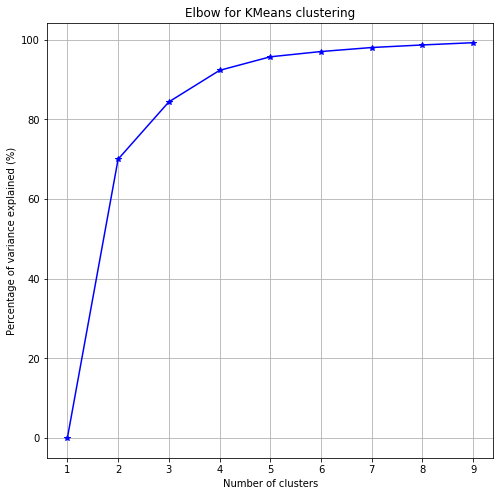

NameError: name 'wcss' is not defined

In [51]:
#Create elbow plot
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    #Create plot
    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)




### Execute modeling on data

In [40]:
#Define number of clusters and construct estimator pipeline
kmeans1 = KMeans(n_clusters=n)

pipeline1 = make_pipeline(kmeans1)

#Fit pipeline to sample data
pipeline1.fit(sample_data)

Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [41]:
#Add labels to pipeline
Labels1 = pipeline1.predict(sample_data)

#Take n cluster centers based on model input and create cluster and label dataframe
centers = pd.DataFrame(kmeans1.cluster_centers_)
df2 = pd.DataFrame({'Cluster': Labels1, 'latitude': sample_data.latitude,'longitude': sample_data.longitude} )

### Create plot of clusters and coordinate assignment

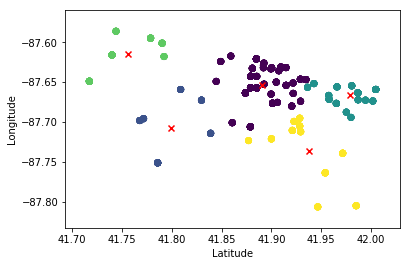

           0          1
0  41.891001 -87.653263
1  41.799143 -87.707897
2  41.978395 -87.665736
3  41.756731 -87.614288
4  41.937559 -87.735910


In [42]:
#Create basic scatter plot for review of clusters and assignments
plt.scatter(df2.latitude,df2.longitude, c= df2.Cluster )
plt.scatter(centers[0], centers[1], marker="x", color='r')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()


#Output cluster coordinates
print(centers)

In [50]:
#Create interactive map visualization color coding cluster values and applying centroids
this_map = folium.Map(location=[41.85,-87.69], zoom_start = 8)

#Loop through coordinates and apply distinct color per cluster label 

for index, row in df2.iterrows():
    if row['Cluster'] == 0:
        folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius = 3, color = 'red').add_to(this_map)
        
    if row['Cluster'] == 1:
        folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius = 3, color = 'orange').add_to(this_map)
        
    if row['Cluster'] == 2:
        folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius = 3, color = 'yellow').add_to(this_map)
        
    if row['Cluster'] == 3:
        folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius = 3, color = 'green').add_to(this_map)
        
    if row['Cluster'] == 4:
        folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius = 3, color = 'blue').add_to(this_map)
        
    if row['Cluster'] == 5:
        folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius = 3, color = 'indigo').add_to(this_map)
        
    if row['Cluster'] == 6:
        folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius = 3, color = 'violet').add_to(this_map)

        
#Plot centroids for each cluster
for index, row in centers.iterrows():
    folium.Marker(location = [row[0], row[1]], radius = 10, color = 'black').add_to(this_map)  
    



#Set map zoom position
this_map.fit_bounds(this_map.get_bounds())

#Save the map to an HTML file
this_map.save('full_html_map_output1.html')
